In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,plot_confusion_matrix, precision_score
from sklearn.metrics import recall_score,roc_auc_score,f1_score,roc_curve, confusion_matrix, f1_score

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("C:\DATASETS\Churn_Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data = data.drop(['RowNumber', 'CustomerId'], axis=1)

### Exploratory Data Analysis 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [5]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Checking for Missing Value
round((data.isnull().sum() * 100/ len(data)),2).sort_values(ascending=False)

Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [7]:
# checking and correcting Outliers using Interquartile method 

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = data.select_dtypes(include=numerics)

for col in numeric_df.columns:
    print(col)
    remove_outlier(numeric_df,col)

CreditScore
Age
Tenure
Balance
NumOfProducts
HasCrCard
IsActiveMember
EstimatedSalary
Exited


<AxesSubplot:>

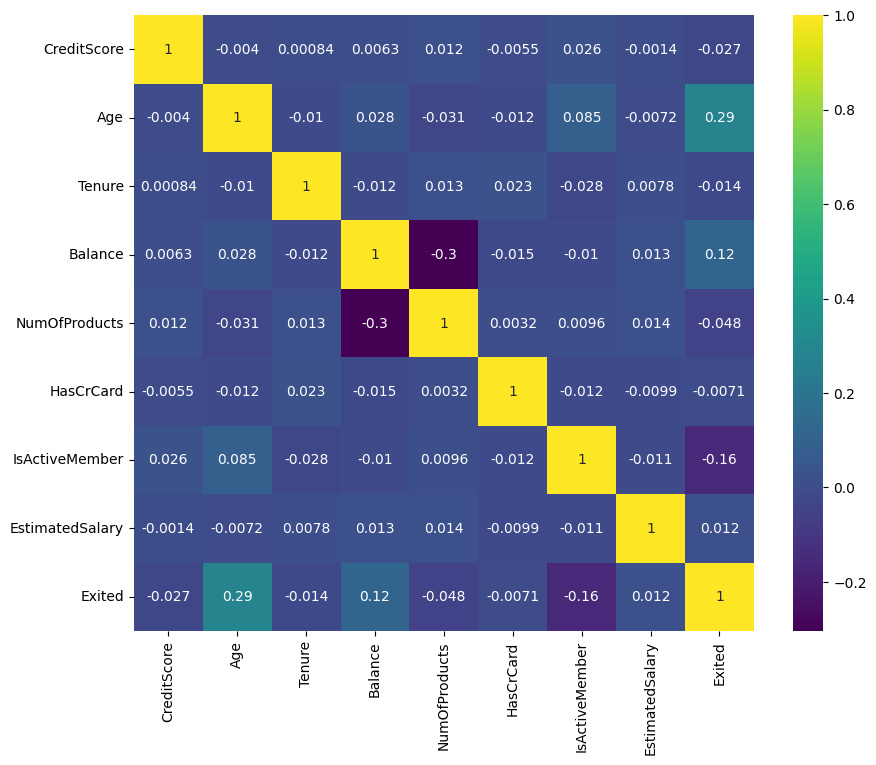

In [8]:
# Correlation Check
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='viridis')

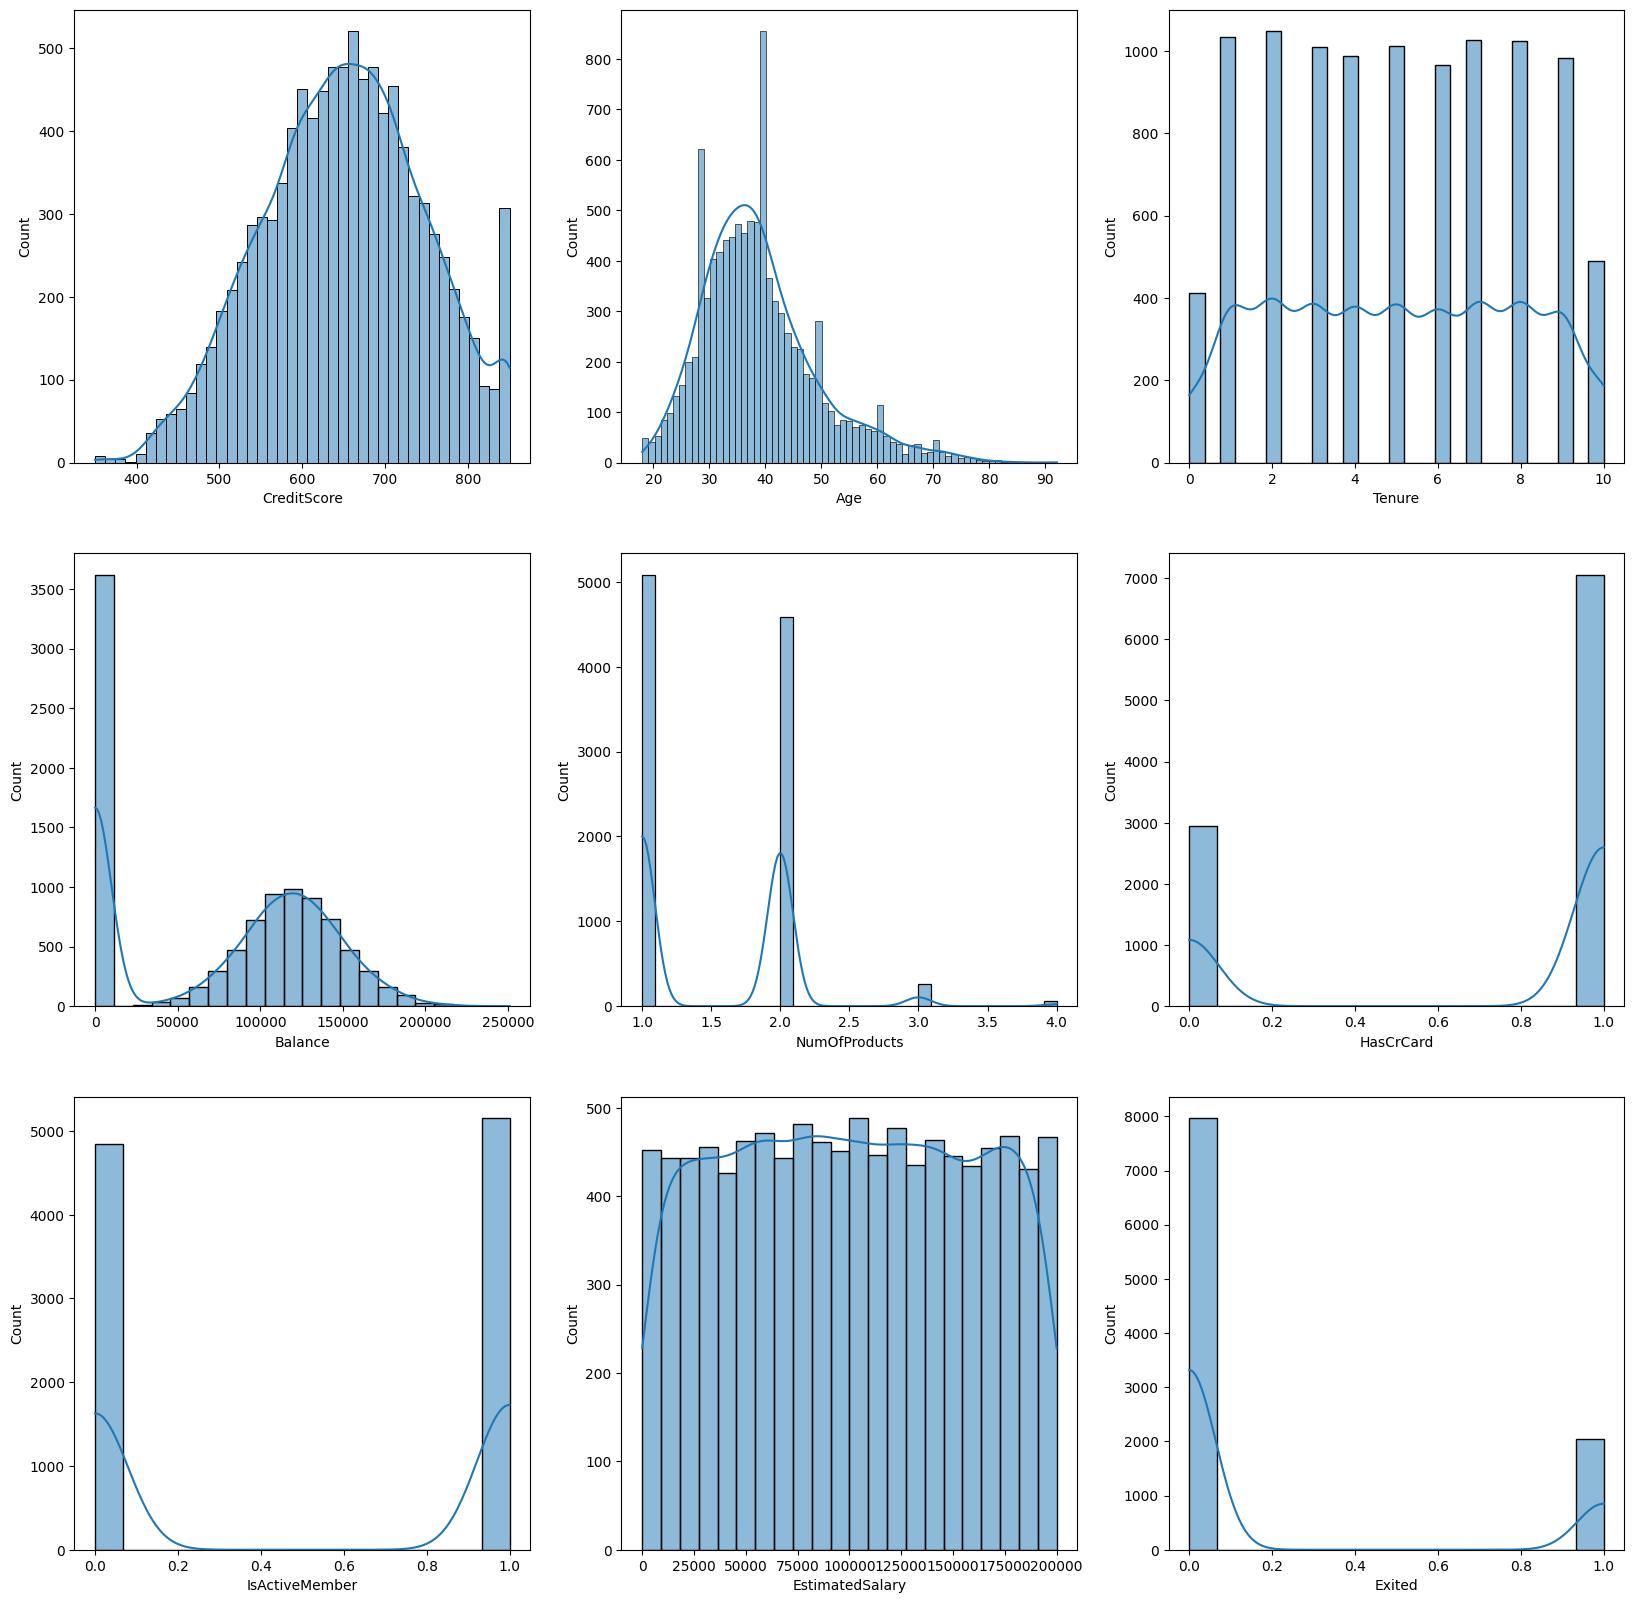

In [9]:
# Univariate Analysis 
fig, axes = plt.subplots(nrows = 3, ncols = 3)    
axes = axes.flatten()         
fig.set_size_inches(20, 20)

for ax, col in zip(axes, numeric_df.columns):
    sns.histplot(numeric_df[col], ax = ax, kde = True)
    #ax.set_title(col)

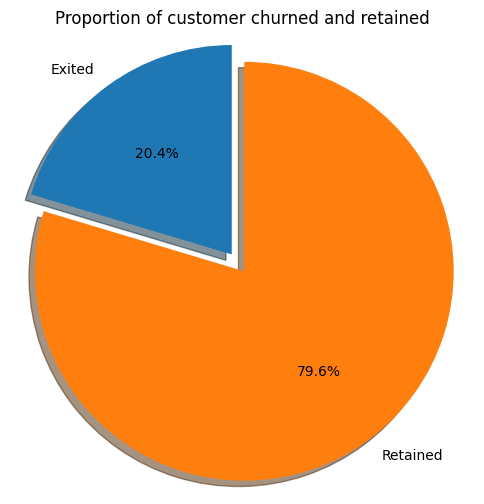

In [10]:
labels = 'Exited', 'Retained'
sizes = [data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 12)
plt.show()

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

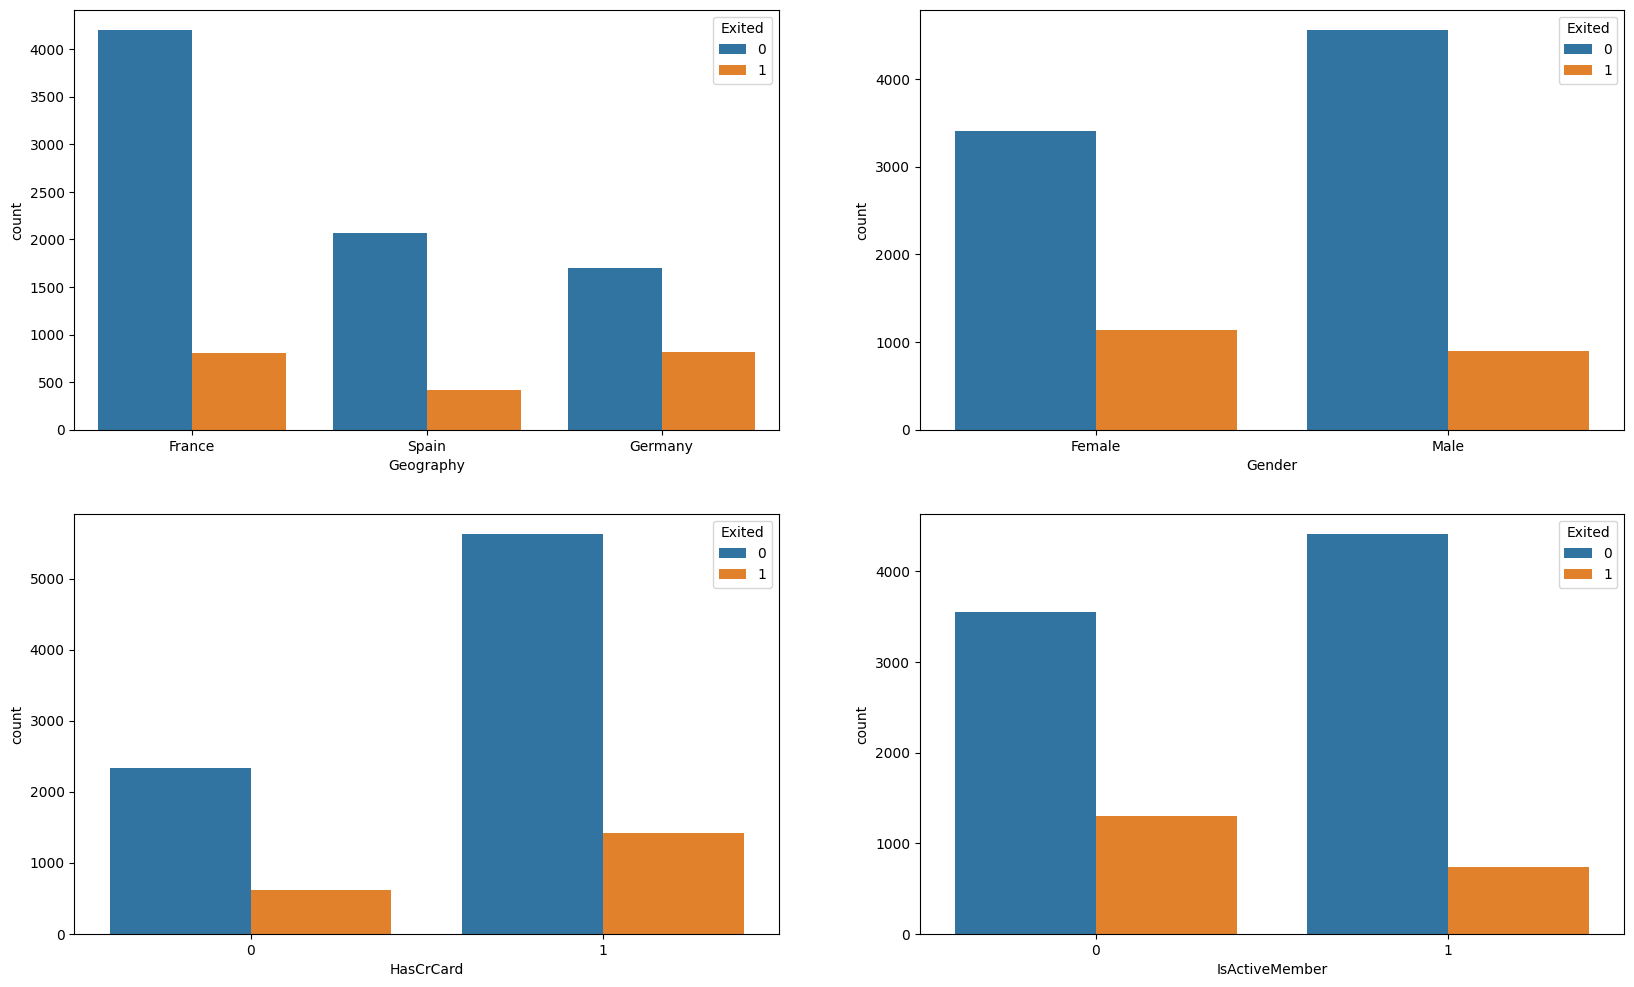

In [11]:
# Bivariate Analysis - Loan Status Count

# Using the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = data, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = data, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = data, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = data, ax=axarr[1][1])

`Inference`


1. The majority of the data originates from individuals in France, it's noteworthy that the proportion of churned customers appears to be inversely related to the customer population in certain areas. This suggests that the bank might encounter issues, potentially related to insufficient customer service resources, in regions with fewer clients.

2. Furthermore, the proportion of female customers churning is higher than that of male customers.

3. It's worth noting that a significant number of customers with credit cards are among those who have churned. However, considering that a substantial portion of the overall customer base also holds credit cards, this observation could potentially be coincidental.

4. Inactive members exhibit a higher churn rate. What's concerning is that the overall proportion of inactive members is quite substantial. This indicates that implementing a program to engage and convert these inactive members into active customers could have a positive impact on reducing customer churn.

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

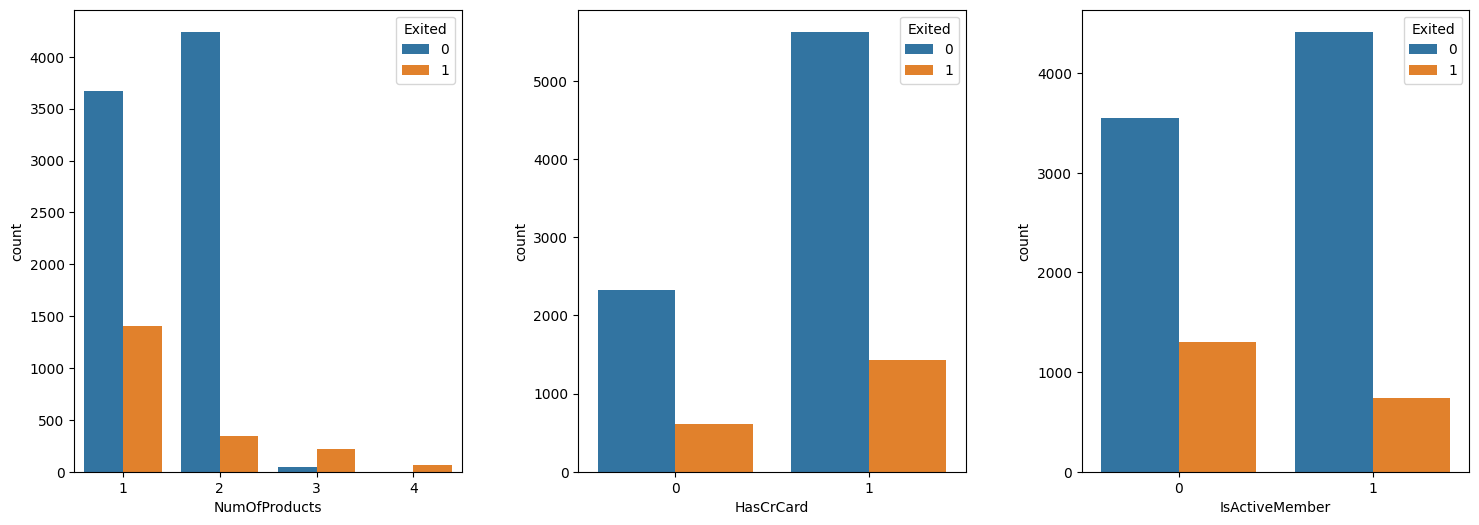

In [12]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
sns.countplot(x = "NumOfProducts", hue="Exited", data = data, ax= ax[0])
sns.countplot(x = "HasCrCard", hue="Exited", data = data, ax = ax[1])
sns.countplot(x = "IsActiveMember", hue="Exited", data = data, ax = ax[2])

* Customer with more than 2 products have higher chances to Churn

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

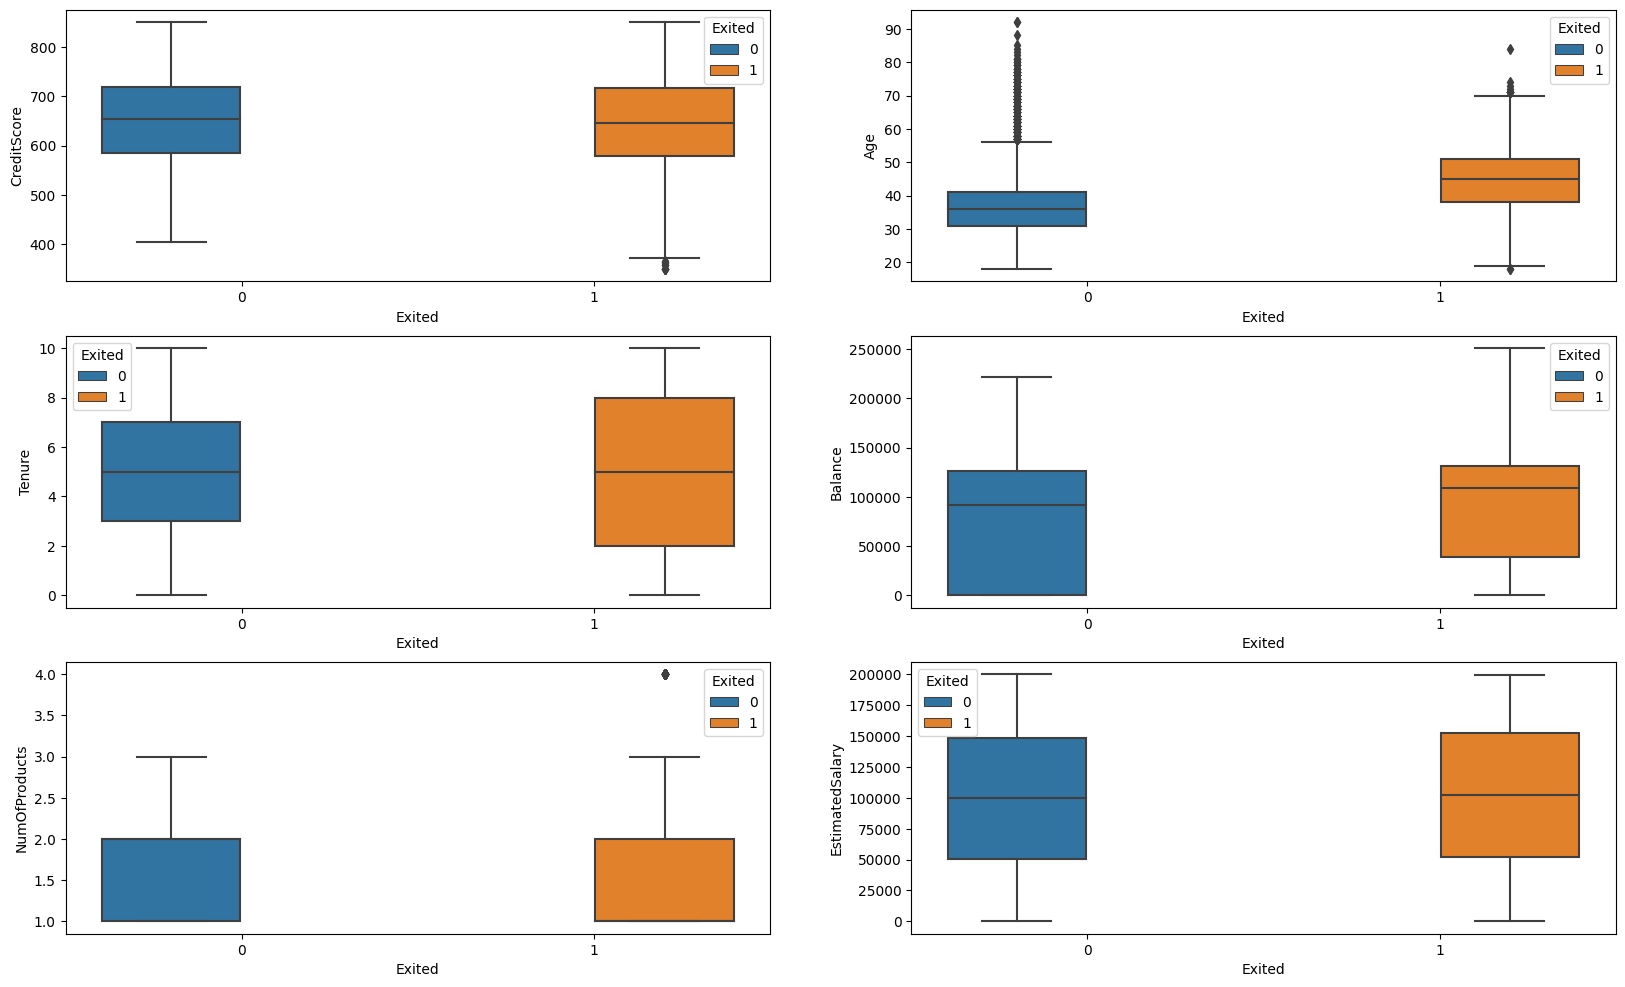

In [13]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = data, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = data , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = data, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = data, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = data, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = data, ax=axarr[2][1])

`Inference`


1. The distribution of credit scores between retained and churned customers does not exhibit a significant difference.

2. Notably, older customers have a higher churn rate compared to younger ones, suggesting varying service preferences among different age groups. The bank may consider revising its target market or retention strategies tailored to these age categories.

3. Regarding tenure, customers at the extremes (those with short or long tenures) are more prone to churn than those with an average tenure, emphasizing the need for targeted retention efforts for such groups.

4. Concerningly, the bank is experiencing customer attrition among individuals with substantial account balances, potentially impacting the bank's available capital for lending.

5. Both product type and salary do not have a significant impact on the likelihood of churn.

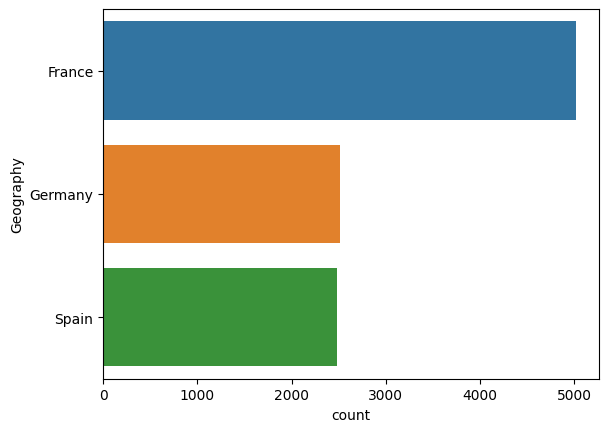

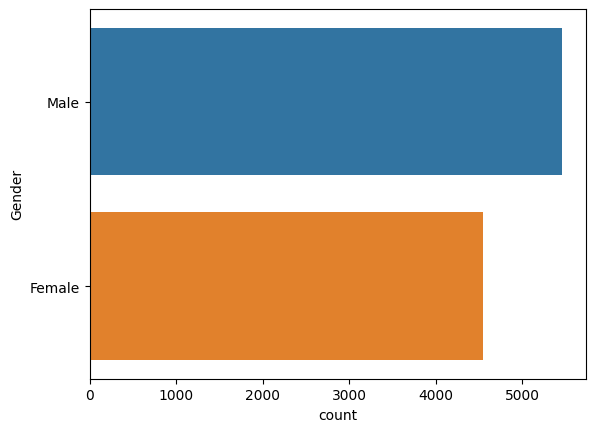

In [14]:
#Vislization of the count of each value in Geography featrure
sns.countplot(y=data['Geography'], data=data, order = data['Geography'].value_counts().index)
plt.show()
#Vislization of the count of each value in Gender feature

sns.countplot(y=data['Gender'], data=data, order = data['Gender'].value_counts().index)
plt.show()

<AxesSubplot:xlabel='Age', ylabel='CreditScore'>

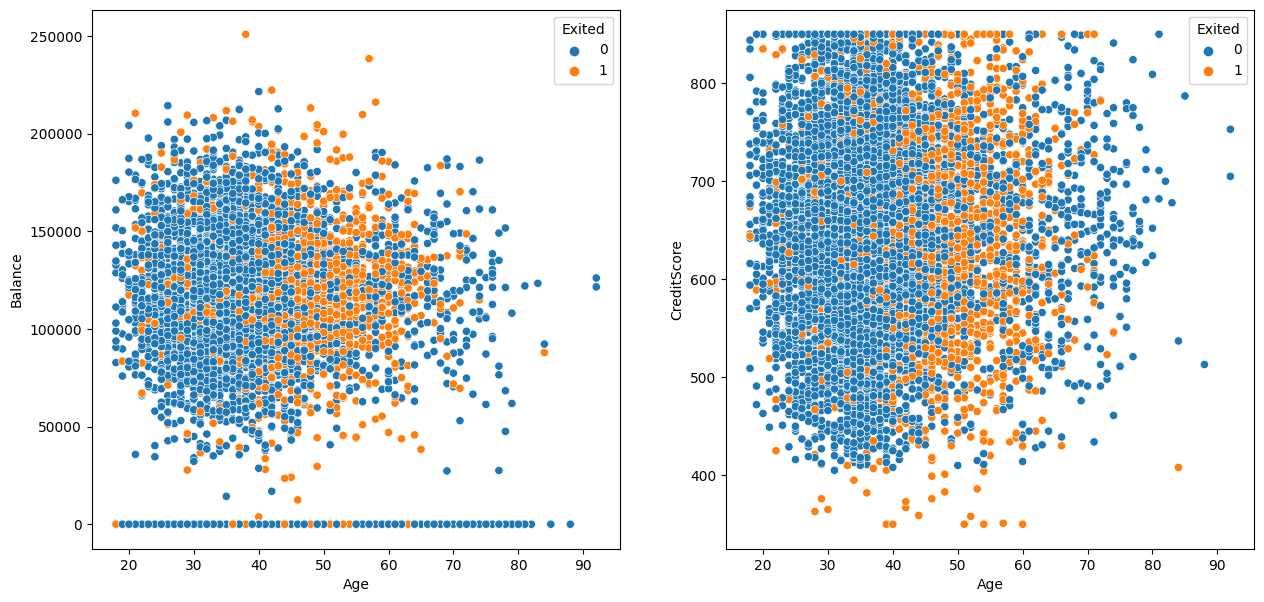

In [15]:
_, ax =  plt.subplots(1, 2, figsize=(15, 7))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.scatterplot(x = "Age", y = "Balance", hue = "Exited", cmap = cmap, sizes = (10, 200), data = data, ax=ax[0])
sns.scatterplot(x = "Age", y = "CreditScore", hue = "Exited", cmap = cmap, sizes = (10, 200), data = data, ax=ax[1])

* 40 to 70 years old customers are higher chances to churn
* Customer with CreditScore less then 400 are higher chances to churn

<AxesSubplot:xlabel='HasCrCard', ylabel='Age'>

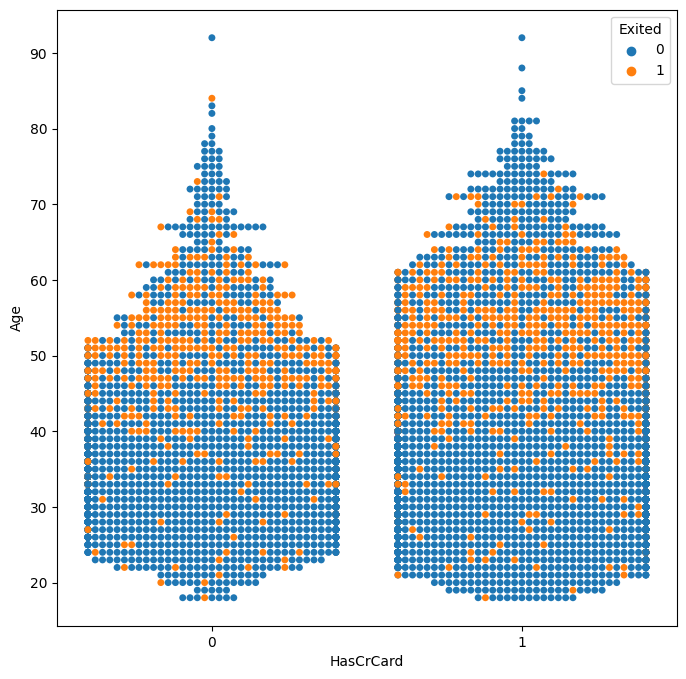

In [16]:
plt.figure(figsize=(8, 8))
sns.swarmplot(x = "HasCrCard", y = "Age", data = data, hue="Exited")

<AxesSubplot:xlabel='Balance', ylabel='CreditScore'>

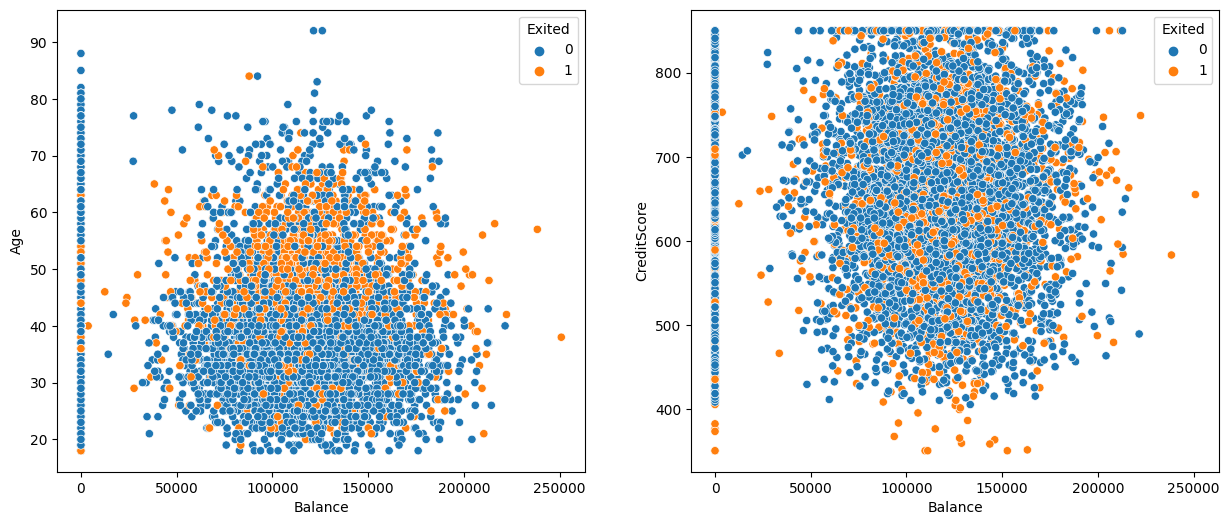

In [17]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x = "Balance", y = "Age", data = data, hue="Exited", ax = ax[0])
sns.scatterplot(x = "Balance", y = "CreditScore", data = data, hue="Exited", ax = ax[1])

In [18]:
data.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [19]:
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Model Building 

In [20]:
# Data Preparations for Model

le = LabelEncoder()

for feat in ['Surname','Geography','Gender']:
    data[feat] = le.fit_transform(data[feat].astype(str))


In [21]:
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1115,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,1177,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,2040,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,289,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,1822,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [22]:
x=data.drop('Exited',axis =1)
y=data.Exited

In [23]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=105)

In [24]:
def train_accuracy(v):
    return(accuracy_score(ytrain,v.predict(xtrain)))

def test_accuracy(w):
    return(accuracy_score(ytest,w.predict(xtest)))
    
def roc_cur(a):
    fpr,tpr,threshold=roc_curve(ytest,a.predict_proba(xtest)[:,1])
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.plot([0,1],[0,1],'r--')
def roc_score(b):
    return(roc_auc_score(ytest,b.predict(xtest)))

def class_report(c):
    print("Classification_report:", classification_report((ytest,c.predict(xtest))))

def sen(d):
    h=confusion_matrix(ytest,d.predict(xtest))
    sensitivity=h[1][1]/((h[1][1]+h[1][0]))
    return sensitivity
def spe(e):
    g=confusion_matrix(ytest,e.predict(xtest))
    sensitivity=g[0][0]/((g[0][0]+g[0][1]))
    return sensitivity

def f_score(f):
    return(f1_score(ytest,f.predict(xtest)))

def f1_w(i):
    labels=[0,1]
    f=f1_score(ytest,i.predict(xtest),average=None,labels=labels)
    return(round(((f[0]*ytest.value_counts()[0])+(f[1]*ytest.value_counts()[1]))/(ytest.value_counts()[0]+ytest.value_counts()[1]),4))


score_card = pd.DataFrame(columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy',
                                       'ROC_Score','Specificity','Sensitivity','f1_weighted_avg'])

def update_score_card(algorithm_name, model):
    
    global score_card

    score_card = score_card.append({'Model_Name': algorithm_name, 'Train_Accuracy': train_accuracy(model),
                                    'Test_Accuracy': test_accuracy(model), 'ROC_Score': roc_score(model),
                                    'Specificity':spe(model),'Sensitivity':sen(model),
                                    'f1_weighted_avg':f1_w(model)}, ignore_index = True)
def scores(a):
    print("Train_Accuracy_Score:",round(accuracy_score(ytrain,a.predict(xtrain)),3))
    print("Test_Accuracy_Score:",round(accuracy_score(ytest,a.predict(xtest)),3))
    print('\n')
    fpr,tpr,threshold=roc_curve(ytest,a.predict_proba(xtest)[:,1])
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.plot([0,1],[0,1],'r--')
    
    print("roc_auc_score:",round(roc_auc_score(ytest,a.predict(xtest)),3))
    print('\n')
    print("Classification_report:\n", classification_report(ytest,a.predict(xtest)))
    
    
    plot_confusion_matrix(a,xtest,ytest)
    print(confusion_matrix(ytest,a.predict(xtest)))

Train_Accuracy_Score: 0.788
Test_Accuracy_Score: 0.792


roc_auc_score: 0.516


Classification_report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      2408
           1       0.35      0.06      0.10       592

    accuracy                           0.79      3000
   macro avg       0.58      0.52      0.49      3000
weighted avg       0.72      0.79      0.73      3000

[[2342   66]
 [ 557   35]]


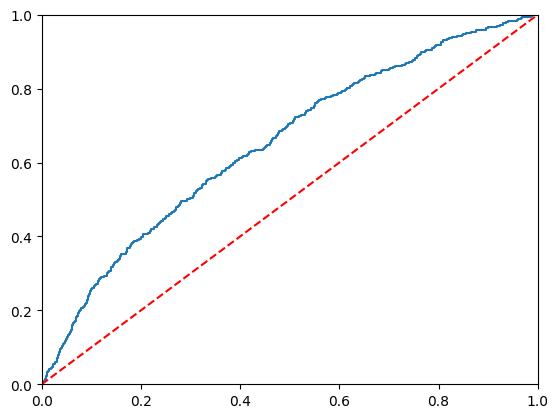

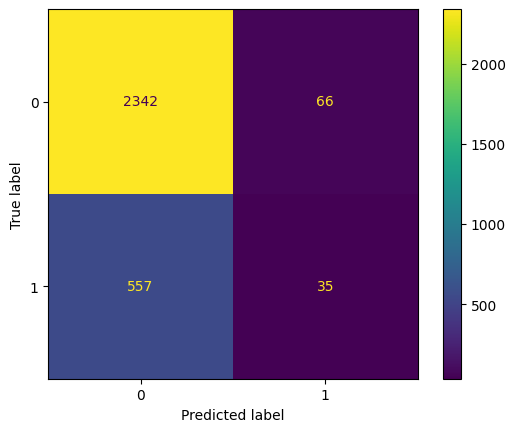

In [25]:
logreg=LogisticRegression(random_state=25)
logreg_model=logreg.fit(xtrain,ytrain)

scores(logreg_model)

update_score_card('LogisticRegression',logreg_model)

Train_Accuracy_Score: 1.0
Test_Accuracy_Score: 0.793


roc_auc_score: 0.686


Classification_report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2408
           1       0.48      0.51      0.49       592

    accuracy                           0.79      3000
   macro avg       0.68      0.69      0.68      3000
weighted avg       0.80      0.79      0.80      3000

[[2078  330]
 [ 291  301]]


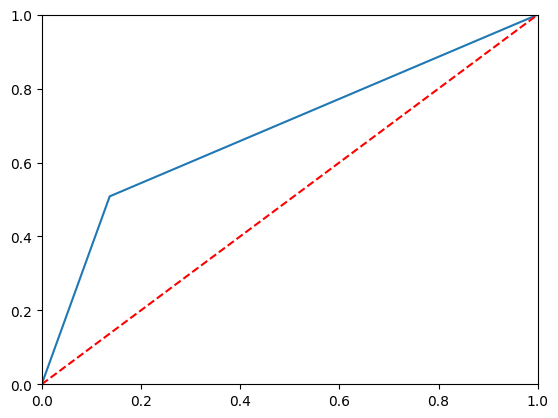

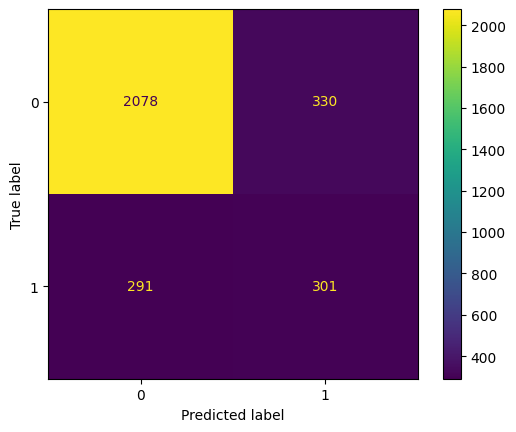

In [26]:
dt=DecisionTreeClassifier()
dt_model=dt.fit(xtrain,ytrain)

scores(dt_model)
update_score_card('DecisionTreeClassifier',dt_model)

Train_Accuracy_Score: 1.0
Test_Accuracy_Score: 0.862


roc_auc_score: 0.711


Classification_report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      2408
           1       0.74      0.46      0.57       592

    accuracy                           0.86      3000
   macro avg       0.81      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000

[[2311   97]
 [ 318  274]]


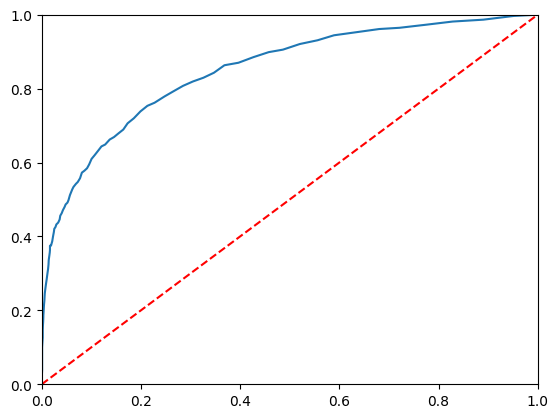

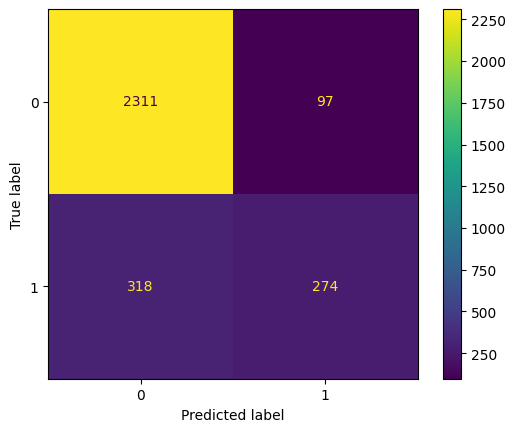

In [27]:
rf=RandomForestClassifier()
rf_model=rf.fit(xtrain,ytrain)

scores(rf_model)
update_score_card('RandomForestClassifier',rf_model)

In [28]:
score_card

,Model_Name,Train_Accuracy,Test_Accuracy,ROC_Score,Specificity,Sensitivity,f1_weighted_avg
0,LogisticRegression,0.788286,0.792333,0.515856,0.972591,0.059122,0.7284
1,DecisionTreeClassifier,1.000000,0.793000,0.685701,0.862957,0.508446,0.7955
2,RandomForestClassifier,1.000000,0.861667,0.711278,0.959718,0.462838,0.8488


Train_Accuracy_Score: 0.974
Test_Accuracy_Score: 0.858


roc_auc_score: 0.726


Classification_report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      2408
           1       0.69      0.51      0.59       592

    accuracy                           0.86      3000
   macro avg       0.79      0.73      0.75      3000
weighted avg       0.85      0.86      0.85      3000

[[2274  134]
 [ 291  301]]


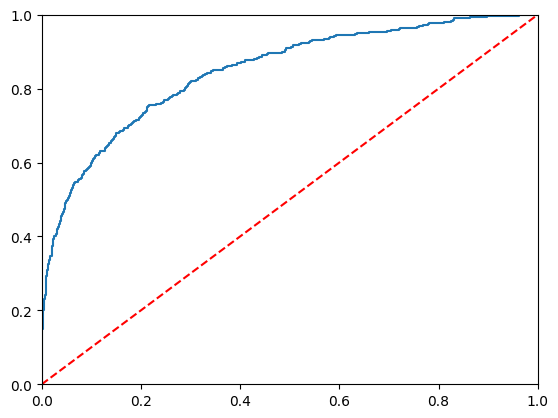

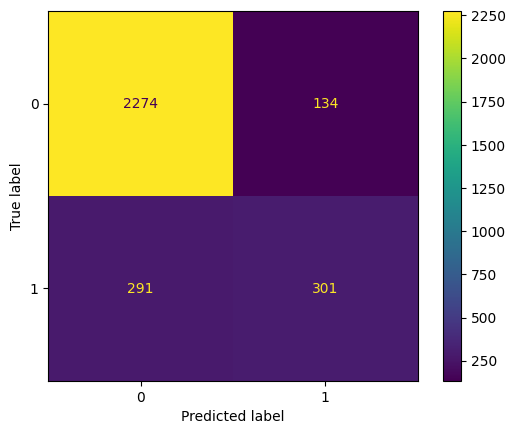

In [29]:
xg=XGBClassifier(random_state=25)
xg_model=xg.fit(xtrain,ytrain)

scores(xg_model)
update_score_card('XGBClassifier',xg_model)

In [30]:
# Assuming you have already created your DataFrame
df_imp = pd.DataFrame(xg_model.feature_importances_, index=xtrain.columns, columns=['Importance']).sort_values('Importance', ascending=False)


In [31]:
df_imp

,Importance
NumOfProducts,0.274371
IsActiveMember,0.198971
Age,0.132986
Geography,0.085598
Gender,0.061696
Balance,0.057299
EstimatedSalary,0.040290
CreditScore,0.039360
Tenure,0.039116
Surname,0.037814


In [32]:
# Check the column names in your DataFrame
print(df_imp.columns)


Index(['Importance'], dtype='object')


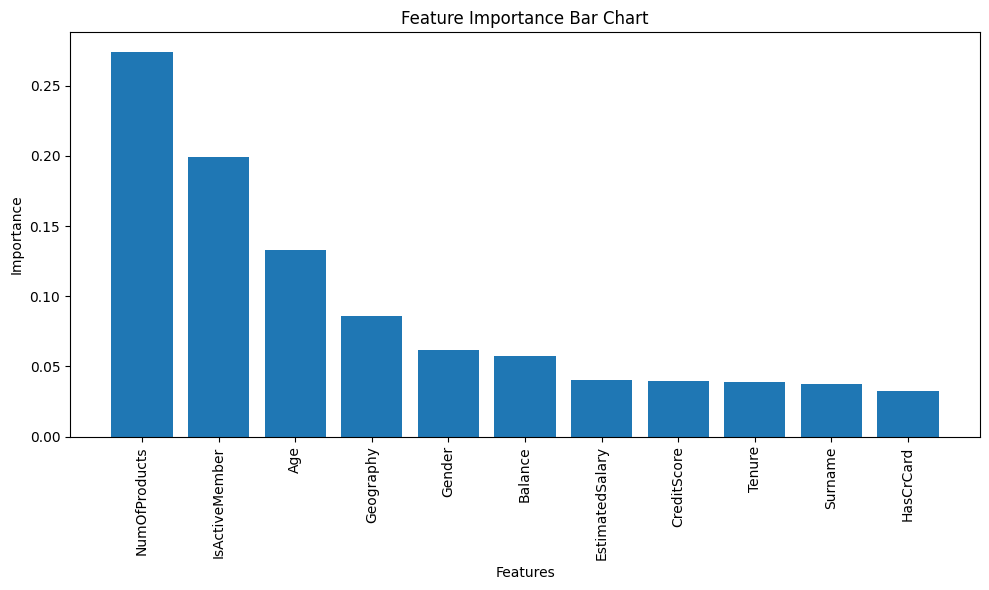

In [33]:

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_imp.index, df_imp['Importance'])
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Bar Chart')
plt.tight_layout()
plt.show()

In [34]:
score_card

,Model_Name,Train_Accuracy,Test_Accuracy,ROC_Score,Specificity,Sensitivity,f1_weighted_avg
0,LogisticRegression,0.788286,0.792333,0.515856,0.972591,0.059122,0.7284
1,DecisionTreeClassifier,1.000000,0.793000,0.685701,0.862957,0.508446,0.7955
2,RandomForestClassifier,1.000000,0.861667,0.711278,0.959718,0.462838,0.8488
3,XGBClassifier,0.973857,0.858333,0.726399,0.944352,0.508446,0.8497
